### Introduction
In this notebook we will implement value iteration and use it to solve the gambler's problem. This is based on the book by Sutton-Barto, specifically this version: https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf

### Choosing a $\gamma$
Recall that $\gamma \in [0, 1]$ is the discount factor used to compute the expected discounted returns
$$G_t = \sum_{k = 0}^\infty \gamma^k R_{t + k + 1}.$$
This hyperparameter $\gamma$ controls how farsighted the agent is, and it also ensures that $G_t$ is finite in the case of infinitely many bounded nonzero terms. (See Sections 3.3, 3.4 in Sutton-Barto.) Choose $\gamma$ for the present case of a finite MDP.

In [1]:
# TODO: define `GAMMA`
GAMMA = 1 


### General objects
Here is a general class template that represents a finite Markov decision process (MDP).

In [2]:
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

class MDP:

    @property
    def states(self):
        '''
        Returns:
            (set) The states of this MDP.
        '''
        pass

    def actions(self, state):
        '''
        How much you are allowed to bet
        Returns:
            (set) The actions allowed from `state`.
        '''
        pass

    def psr(self, state, action):
        '''
        Returns:
            (set) The set of tuples (p, s, r) where `s` is a state reachable
                from `state` by performing `action`, `p` is the probability
                of reaching `s`, and `r` is the reward gained by reaching `s`.
                In particular, the sum of the `p` equals 1.
        '''
        pass

### Implementing the gambler's problem
To make our implementation compatible with value iteration, we will include the state `self.goal`. Recall that the reward of reaching the goal is $1$ and that the reward of reaching any other state is $0.$ Moreover, recall that the MDP ends once either `0` or `self.goal` is reached. How should the state `self.goal` behave, e.g. what should the available actions and rewards from this state be? With this in mind, fix the below naive implementation of the gambler's problem. You can use the rest of the notebook (in particular the last cell) to test your implementation.

In [3]:
class GamblersProblem(MDP):
    '''
    The gambler's problem, as described in Example 4.3 of Sutton-Barto.
    '''
    
    def __init__(self, p_h, goal):
        assert 0 <= p_h <= 1
        self.p_h = p_h
        self.goal = goal

    @property
    def states(self): # TODO: fix this
        return set(range(self.goal+1))

    def actions(self, state): # TODO: fix this. Doesn't currently allow the state 100
        # don't allow positive bets when you're at 100
        # the actions at the goal are {0} and the reward
        # before: return set(range(min(state, self.goal - state)))
        if state in {0, self.goal}:
            return {0}
        else:
            return set(range(1, 1+min(state, self.goal-state))) # start the bets from 1

    # Probability State Reward
    # probability of it happening
    # state you reach
    # the reward you get
    def psr(self, state, action): # TODO: fix this
        return {
            (
                self.p_h, # heads, i.e. the gambler wins money
                state + action,
                1 if state + action == self.goal and (action > 0) else 0
            ), (
                1 - self.p_h, # tails, i.e. the gambler loses money
                state - action,
                0
            ) 
        }

    def plot_policy(self, policy):
        for s, actions in policy.items():
            xy = [(s, action) for action in actions]
            plt.scatter(
                *zip(*xy),
                # purple if there are multiple actions
                color='purple' if len(actions) > 1 else 'blue', 
                marker='.'
            )

    def plot_value(self, value):
        xy = [(s, v) for s, v in value.items()]
        plt.plot(*zip(*xy))

### Value functions

Here is a general class that represents a value function on a finite MDP. Implement the `truncated_evaluations` and `greedy_policy` methods, replacing the currently obfuscated code, recalling that the truncated evaluation (see Section 4.4 in Sutton-Barto) for a value function $v,$ a state $s,$ and an action $a$ is
$$\mathbb{E}[R_{t + 1} + \gamma v(S_{t + 1}) \mid S_t = s, A_t = a] = \sum_{(s', r)} p(s', r \mid s, a)[r + \gamma v(s')].$$

In [4]:
class Value(dict):

    def truncated_evaluations(self, mdp):
        '''
        Returns:
            (dict) The truncated policy evaluations for every state and
                every action. The keys are the states, and the values are
                dicts keyed by actions with value the truncated policy
                evaluation of performing the action at the state.
        '''
        eval={
            a: {
                state: sum(
                    s_prime*(s+GAMMA*self[p])
                    for s_prime,p,s in mdp.psr(a,state)
                )
                for state in mdp.actions(a)
            }
            for a in mdp.states
        }
        return eval
        

    def greedy_policy(self, mdp, tiebreak='equal_split'):
        '''
        The greedy policy (with respect to the truncated policy evaluations).

        Args:
            tiebreaker: Decides what to do in case there are multiply actions
                with the same truncated policy evaluation. The options are
                'equal_split' (of the probabilities), 'max' (of the actions),
                'min' (of the actions), 'random' (action).
        '''
        greedy_actions = {
            s: {a for a, v in evals.items() if v == max(evals.values())}
            for s, evals in self.truncated_evaluations(mdp).items()
        }
        tiebreaker = lambda actions: {
            'equal_split': {a: 1 / len(actions) for a in actions},
            'max': {max(actions): 1.0},
            'min': {min(actions): 1.0},
            'random': {random.choice(list(actions)): 1.0},
        }[tiebreak]
        return {
            s: tiebreaker(actions)
            for s, actions in greedy_actions.items()
        }

### Value iteration algorithm
The pseudocode for value iteration in Sutton-Barto (see Figure 4.5 in Sutton-Barto on page 101) has a slight error. Namely, it is using asynchronous dynamic programming (see the following Section 4.5 in Sutton-Barto) because it updates $V(s)$ in place, i.e. it is using the updated value of $V(s)$ for the subsequent computations of $V(s')$ for other $s'.$ The pseudocode is also non-Pythonic. Below is an implementation following their pseudocode, which we will use during section. Reimplement this so that it is the intended algorithm and in a Pythonic way.

In [5]:
def value_iteration_algorithm(mdp, theta=1e-15, max_iter=1000, tiebreak='equal_split'):
    '''
    The value iteration algorithm (but not really, because see above) following
    the pseudocode in Sutton-Barto.
    '''
    V = Value({state: 0 for state in mdp.states})
    pbar = tqdm(range(max_iter))
    for iter in pbar:
        Delta = 0
        evaluations = V.truncated_evaluations(mdp)
        for s in mdp.states:
            temp = max(evaluations[s].values())
            Delta = max(Delta, abs(V[s] - temp))
            V[s] = temp
        if Delta < theta:
            break
        mdp.plot_value(V)
        pbar.set_description(f'{Delta=:<6.3}  {V[50]=:<6.3}  {V[100]=:<6.3}')
    plt.show()

    return V.greedy_policy(mdp, tiebreak=tiebreak)

The value iteration algorithm updates the value function for each state by considering all possible actions and their corresponding rewards and next states. It calculates the expected value by taking the maximum over all possible actions. This allows the algorithm to consider all possible actions and choose the one that maximizes the expected return. By considering all actions, the algorithm ensures that it explores the entire state-action space and finds the optimal policy.

### Playing around with the gambler's problem
Use the cell below to test various values of $p_h.$

Delta=0.141   V[50]=0.25    V[100]=0.0   :   0%|          | 0/1000 [00:00<?, ?it/s]

Delta=2.33e-15  V[50]=0.25    V[100]=0.0   :   4%|▍         | 41/1000 [00:00<00:04, 204.63it/s]


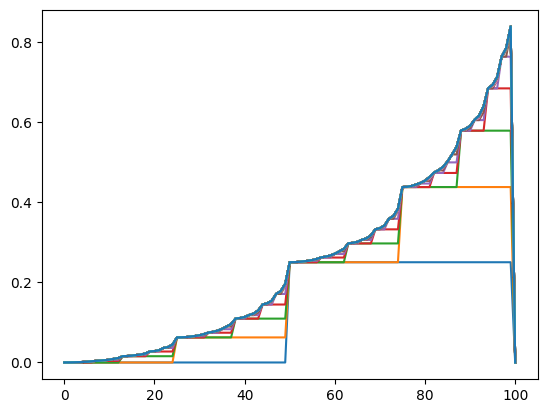

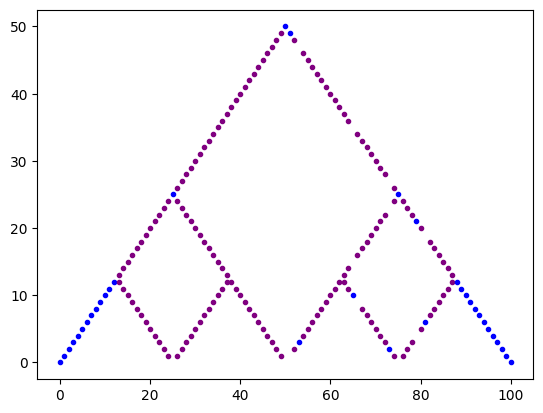

In [6]:
mdp = GamblersProblem(0.25, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

Delta=0.0503  V[50]=0.587   V[100]=0.0   :   0%|          | 0/1000 [00:00<?, ?it/s]

Delta=4.73e-05  V[50]=0.999   V[100]=0.0   : 100%|██████████| 1000/1000 [00:04<00:00, 248.29it/s]


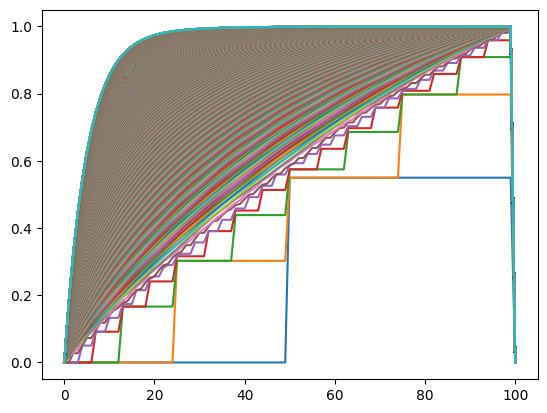

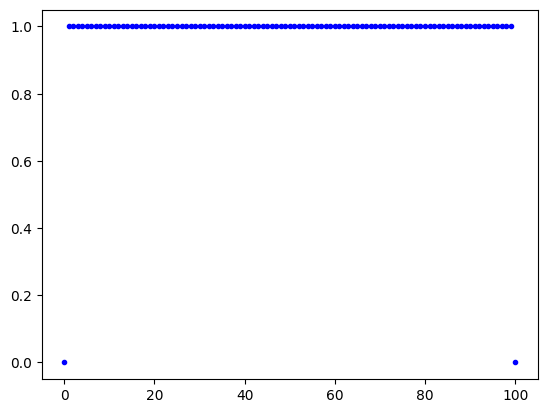

In [7]:
mdp = GamblersProblem(0.55, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

The value function graph shows the expected return for each state (capital). With a higher p (0.55 vs 0.25), the gambler has a higher chance of winning each bet, so the expected return would generally be higher for all states. Therefore, the value function graph for gamblerproblem(0.55, 100) would generally be above the graph for gamblerproblem(0.25, 100).

For any p > 0.5, it is clear there is only one correct solution. Intuitively, since we are expected to win more than we lose, the optimal policy should be to maximize the number of bets, which is achieved by betting the minimal amount of 1 no matter what the state is. Given no time restraint, we expect this policy to be optimal.

On the other hand, there are multiple optimal policies for p < 0.5, which is why we see three different policies on the graph. One has a single peak, the second has two peaks, and the last has four. Note that between all three policies, the values at 25, 50, 75 are all the same at \$25, \$50, \$25 respectively. The three policies all follow the same principle of minimizing the number of bets since the longer the game goes on, the more likely the gambler is to lose. We do so by always going all in at 50, but outside of that, they differ slightly (although the values of the different actions are identical). For example, at \$51, the maximum optimal bet is $49 to straight up win (losing would still result in \$2 left) and the minimum optimal bet is \$1 to try and build up to \$75 (losing would just mean going all in at $50).